# Difference Features - LB 0.600
In this notebook we create difference features based on Kvigly's published PDBs [here][1]. For each test mutation we compute the difference between `pLDDT` mutation minus `pLDDT` wildtype. We notice that this submission is very diverse from the existing public notebooks (which mainly focus on wild type protein). Therefore when we ensemble this submission with the best public notebook we observe boost in CV LB!

We can boost CV LB more by creating more difference features between wild type and mutation using PDB files. For example, another recent diverse high scoring notebook is greySnow's difference PDB feature bewtween energy scores [here][2]

[1]: https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/361816
[2]: https://www.kaggle.com/code/shlomoron/nesp-relaxed-rosetta-scores

# Load Test Data

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt
from scipy.stats import rankdata

In [2]:
test = pd.read_csv('data/test.csv')
deletions = test.loc[test.protein_sequence.str.len()==220,'seq_id'].values
test.head()

,seq_id,protein_sequence,pH,data_source
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes


In [3]:
# LOAD TEST WILDTYPE
base = 'VPVNPEPDATSVENVALKTGSGDSQSDPIKADLEVKGQSALPFDVDCWAILCKGAPNVLQRVNEKTKNSNRDRSGANKGPFKDPQKWGIKALPPKNPSWSAQDFKSPEEYAFASSLQGGTNAILAPVNLASQNSQGGVLNGFYSANKVAQFDPSKPQQTKGTWFQITKFTGAAGPYCKALGSNDKSVCDKNKNIAGDWGFDPAKWAYQYDEKNNKFNYVGK'
len(base)

221

In [4]:
def get_test_mutation(row):
    for i,(a,b) in enumerate(zip(row.protein_sequence,base)):
        if a!=b: break
    row['wildtype'] = base[i]
    row['mutation'] = row.protein_sequence[i]
    row['position'] = i+1
    return row
test = test.apply(get_test_mutation,axis=1)
test.loc[test.seq_id.isin(deletions),'mutation'] = '_'
test.head()

,seq_id,protein_sequence,pH,data_source,wildtype,mutation,position
0,31390,VPVNPEPDATSVENVAEKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,L,E,17
1,31391,VPVNPEPDATSVENVAKKTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,L,K,17
2,31392,VPVNPEPDATSVENVAKTGSGDSQSDPIKADLEVKGQSALPFDVDC...,8,Novozymes,L,_,17
3,31393,VPVNPEPDATSVENVALCTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,K,C,18
4,31394,VPVNPEPDATSVENVALFTGSGDSQSDPIKADLEVKGQSALPFDVD...,8,Novozymes,K,F,18


# Load PDBs Provided by Kvigly
We load the PDBs provided by Kvigly (discussion [here][1]) and extract the `pLDDT` from wild type and mutation. Then we compute the difference.

[1]: https://www.kaggle.com/competitions/novozymes-enzyme-stability-prediction/discussion/361816

In [5]:
# !pip install biopandas
from biopandas.pdb import PandasPdb

# TEST WILD TYPE
atom_df0 = PandasPdb().read_pdb(f'data/kvigly-test-mutation-pdbs/WT_unrelaxed_rank_1_model_3.pdb')
atom_df0 = atom_df0.df['ATOM']
wt = atom_df0.groupby('residue_number').b_factor.agg('first').values

# EDA Structure Difference
Below we display 3D structure of test wild type vs. test row 1 mutation as predicted by Alpha Fold.

## Test Wildtype

In [8]:
# !pip install py3Dmol -q

In [10]:
import py3Dmol 
with open("data/wildtype_structure_prediction_af2.pdb") as ifile:
    protein = "".join([x for x in ifile])
#view = py3Dmol.view(query='pdb:1DIV', width=800, height=600)
view = py3Dmol.view(width=800, height=600) 
view.addModelsAsFrames(protein)
style = {'cartoon': {'color': 'spectrum'},'stick':{}}
view.setStyle({'model': -1},style) 
view.zoom(0.12)
view.rotate(235, {'x':0,'y':1,'z':1})
view.spin({'x':-0.2,'y':0.5,'z':1},1)
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Test Mutation Row 1

In [11]:
with open("data/kvigly-test-mutation-pdbs/L17E_unrelaxed_rank_1_model_3.pdb") as ifile:
    protein = "".join([x for x in ifile])
#view = py3Dmol.view(query='pdb:1DIV', width=800, height=600)
view = py3Dmol.view(width=800, height=600) 
view.addModelsAsFrames(protein)
style = {'cartoon': {'color': 'spectrum'},'stick':{}}
view.setStyle({'model': -1},style) 
view.zoom(0.12)
view.rotate(235, {'x':0,'y':1,'z':1})
view.spin({'x':-0.2,'y':0.5,'z':1},1)
print
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# EDA pLDDT Difference
Below we display the difference of pLDDT of test wild type vs. test row 1 mutation as predicted by Alpha Fold.

In [12]:
for index,row in test.iterrows():
    aa1 = row.wildtype; aa2 = row.mutation; pos = row.position
    atom_df = PandasPdb().read_pdb(f'data/kvigly-test-mutation-pdbs/{aa1}{pos}{aa2}_unrelaxed_rank_1_model_3.pdb')
    atom_df = atom_df.df['ATOM']
    mut = atom_df.groupby('residue_number').b_factor.agg('first').values
    break

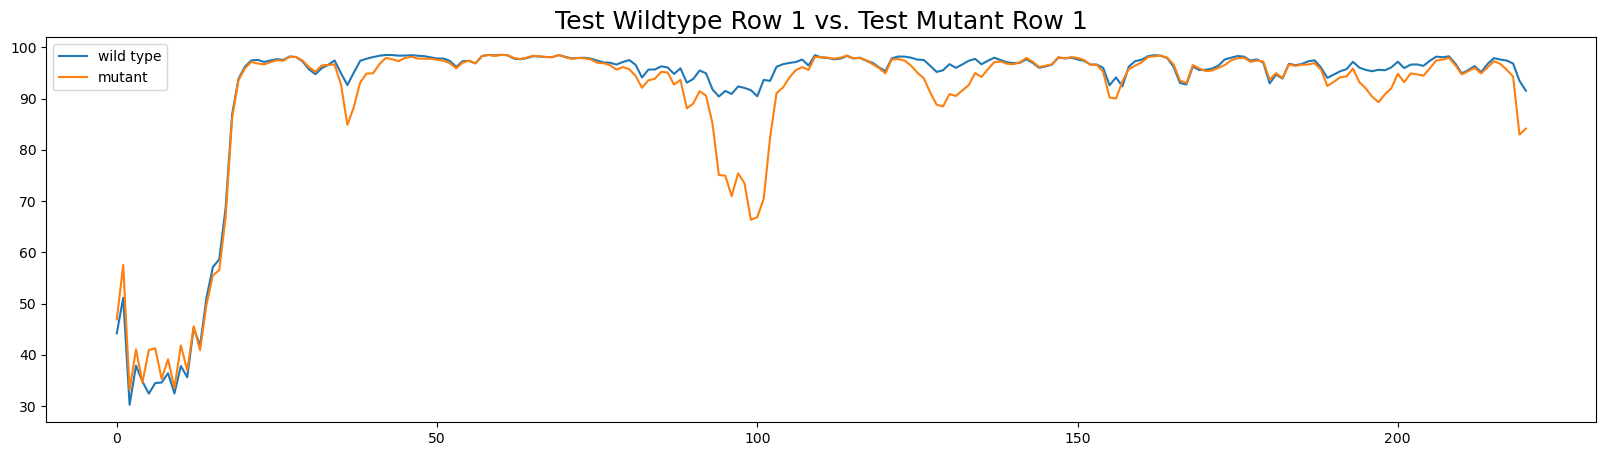

In [13]:
plt.figure(figsize=(20,5))
plt.plot(range(221),wt,label='wild type')
plt.plot(range(221),mut,label='mutant')
plt.legend()
plt.title('Test Wildtype Row 1 vs. Test Mutant Row 1',size=18)
plt.show()

# Compute Difference Mutation vs. Wild Type Feature

In [15]:
diffs = []
missing = []

for index,row in test.iterrows():
    #print(index,', ',end='')
    aa1 = row.wildtype
    aa2 = row.mutation
    pos = row.position
    d = 0
    try:
        atom_df = PandasPdb().read_pdb(f'data/kvigly-test-mutation-pdbs/{aa1}{pos}{aa2}_unrelaxed_rank_1_model_3.pdb')
        atom_df = atom_df.df['ATOM']
        mut = atom_df.groupby('residue_number').b_factor.agg('first').values
        d = mut[pos-1] - wt[pos-1]
    except:
        missing.append(index)
        
    diffs.append(d)
print('These PDB are missing:', missing )

These PDB are missing: [1169]


# Create Submission CSV
We publish both single model CSV and ensemble with best public notebook CSV.

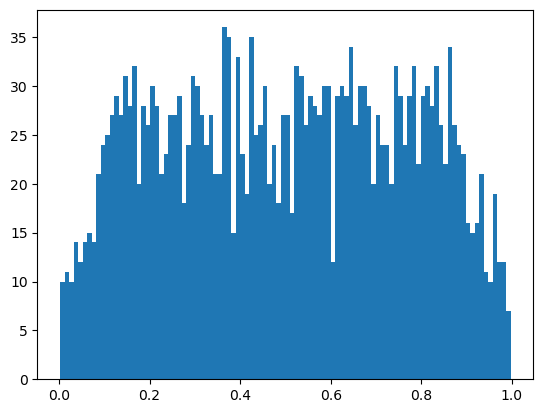

In [18]:
sub = pd.read_csv('data/sample_submission.csv')
sub['tm'] = diffs
sub.to_csv('submissions/pLDDT_diff_submission_single.csv',index=False)

best = pd.read_csv('data/thermonet/ensemble_submission.csv')
best.tm = rankdata( best.tm )
best.head()

submission = sub.copy()
submission.tm = (0.15 * rankdata(sub.tm) + 0.85 * rankdata(best.tm))/len(submission)
plt.hist(submission.tm, bins=100)
plt.show()
submission.to_csv('submissions/pLDDT_diff_submission_ensemble.csv',index=False)